# Classify DvH mono vs. co-culture

### Test classification on Dvh in mono- vs. co-culture only! (use only monoculture conditions in lactate)

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import pandas as pd
pd.options.display.mpl_style = 'default'

from mpltools import style
from mpltools import layout

style.use('ggplot')

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size, height=100):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
## see https://stackoverflow.com/questions/14656852/how-to-use-pandas-dataframes-and-numpy-arrays-in-rpy2
## and http://ipython.org/ipython-doc/rel-0.13/config/extensions/rmagic.html
## note there's a ri2pandas() to convert back.
## but note, rpy2 2.4.0 and later automagically translates dataframes: 
## https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
%load_ext rpy2.ipython
%Rdevice svg
#import rpy2.robjects.pandas2ri as p2r
#rdf = p2r.pandas2ri(info)
#%Rpush rdf

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%run -i read_counts.py

In [49]:
sample_info = pd.read_excel('Sample_Info_FIXED2.xlsx') ##,skiprows=[0])
sample_info = sample_info.drop( ['growth rate per h (OLD)', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Sample name.1'], 1)
sample_info = sample_info.set_index( sample_info['Sample name'] )
sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
info = sample_infos['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
sizeme(info.head(3),50,120)

,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_US-1505885,Sample_US-1505885,Labcorp,US-1505885,PS 37 C log 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",sulfate respiration/growth,pyruvate 80mM,pyruvate,NaN,sulfate,0.13,37,D vulgaris Hildenborugh,NaN
Sample_US-1505888,Sample_US-1505888,Labcorp,US-1505888,LS 37C log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,0.11,37,D vulgaris Hildenborugh,NaN
Sample_US-1505895,Sample_US-1505895,Labcorp,US-1505895,LS 37C e. stat 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",fermentation,lactate 10mM,lactate,10,none,0.00,37,D vulgaris Hildenborugh,0


In [50]:
((info['organisms']=='D vulgaris Hildenborugh and M maripaludis').values | 
 (info['organisms']=='D vulgaris Hildenborugh').values) & (info['electron donor']=='lactate').values

array([False,  True,  True, False,  True, False,  True,  True,  True,
       False, False, False,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True, False, False, False,  True, False,
       False,  True, False,  True, False, False,  True, False, False,
       False, False,  True], dtype=bool)

In [52]:
info2 = info[((info['organisms']=='D vulgaris Hildenborugh and M maripaludis').values | 
              (info['organisms']=='D vulgaris Hildenborugh').values) & 
             (info['electron donor']=='lactate').values]
print(info2.shape)
sizeme(info2,50,120)

(32, 16)


,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_US-1505888,Sample_US-1505888,Labcorp,US-1505888,LS 37C log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,0.110,37,D vulgaris Hildenborugh,NaN
Sample_US-1505895,Sample_US-1505895,Labcorp,US-1505895,LS 37C e. stat 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",fermentation,lactate 10mM,lactate,10,none,0.000,37,D vulgaris Hildenborugh,0.000
Sample_US-1505898,Sample_US-1505898,Labcorp,US-1505898,L 37C coculture e. stat 1,batch,NaN,lactate 40mM 37C,syntrophy/growth,lactate 40mM,lactate,NaN,proton/hydrogenotroph,0.000,37,D vulgaris Hildenborugh and M maripaludis,0.027
Sample_US-1505946,Sample_US-1505946,Labcorp,US-1505946,L 37C coculture log 1,batch,NaN,lactate 40mM 37C,syntrophy/growth,lactate 40mM,lactate,NaN,proton/hydrogenotroph,0.030,37,D vulgaris Hildenborugh and M maripaludis,0.047
Sample_US-1505947,Sample_US-1505947,Labcorp,US-1505947,L 37C coculture e.stat 2,batch,NaN,lactate 40mM 37C,syntrophy/growth,lactate 40mM,lactate,NaN,proton/hydrogenotroph,0.000,37,D vulgaris Hildenborugh and M maripaludis,0.047
Sample_US-1505949,Sample_US-1505949,Labcorp,US-1505949,LS 37C e. stat 2,batch,NaN,"lactate 40mM, sulfate15mM 37C",fermentation,lactate 10mM,lactate,10,none,0.000,37,D vulgaris Hildenborugh,0.050
Sample_US-1505967,Sample_US-1505967,Labcorp,US-1505967,"L 37C coculture log 3, Serdar standard",batch,NaN,lactate 40mM 37C,syntrophy/growth,lactate 40mM,lactate,NaN,proton/hydrogenotroph,0.030,37,D vulgaris Hildenborugh and M maripaludis,0.027
Sample_US-1505985,Sample_US-1505985,Labcorp,US-1505985,L 37C coculture log 2,batch,NaN,lactate 40mM 37C,syntrophy/growth,lactate 40mM,lactate,NaN,proton/hydrogenotroph,0.030,37,D vulgaris Hildenborugh and M maripaludis,0.027
Sample_US-1505998,Sample_US-1505998,Labcorp,US-1505988,LS 37C log 2,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,0.110,37,D vulgaris Hildenborugh,NaN


### Identify groups of replicates in the measurements -- using groupby

In [53]:
info = info2
#info_tmp = info[info.columns[np.hstack([4,np.arange(6,14)])]]  ##.duplicated()
group_cols = info.columns[np.hstack([4,6,7,8,9,11,12,13,14])].values.astype(str).tolist()
#grouped = info.groupby(info.columns[np.hstack([4,np.arange(6,14)])].values)
#group_cols = ['cultivation type', 'Description/condition details',
#             'Description/condition details -2', 'carbon source', 'electron donor',
#             'concentration (mM)', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
print group_cols
grouped = info.groupby(group_cols, axis=0)
print len(grouped.groups), info.shape, info[group_cols].drop_duplicates().shape
#print grouped.groups[grouped.groups.keys()[0]]
print [len(i) for i in grouped.groups.values()]
col_groups = grouped.groups.values()
for i in grouped.groups.values():
    print i
    #print info.ix[i]['Description/condition details'].values
col_groups = grouped.groups.values()

['cultivation type', 'Description/condition details', 'Description/condition details -2', 'carbon source', 'electron donor', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
11 (32, 16) (11, 9)
[2, 3, 3, 3, 2, 2, 2, 3, 3, 5, 4]
['Sample_US-1510836', 'Sample_US-1510848']
['Sample_US-1505946', 'Sample_US-1505967', 'Sample_US-1505985']
['Sample_US-1505888', 'Sample_US-1505998', 'Sample_US-1510873']
['Sample_US-1510865', 'Sample_US-1510891', 'Sample_US-1510901']
['Sample_US-1510854', 'Sample_US-1510870']
['Sample_US-1510853', 'Sample_US-1510856']
['Sample_US-1505898', 'Sample_US-1505947']
['Sample_US-1510871', 'Sample_US-1510882', 'Sample_US-1510888']
['Sample_US-1505895', 'Sample_US-1505949', 'Sample_US-1510877']
['Sample_US-1510845', 'Sample_US-1510852', 'Sample_US-1510859', 'Sample_US-1510864', 'Sample_US-1510895']
['Sample_US-1510829', 'Sample_US-1510840', 'Sample_US-1510866', 'Sample_US-1510868']


## OK, idea: remove all replicates of a given measurement, run Boruta to get big, best subset of variables that classify, then random forest (lots of trees) using those variables to get classifier. Test (predict) the random forest on the left-out measurements.

### Now do it for all test cases! -- i.e., all replicate sets

In [10]:
%%R -n
load('Untitled5.RData')
load('Untitled6.RData')
rm(B.ea2,B.ed2,B.temp1,B.temp2,B.ea1,B.ea1a,B.ed1,B.gr1)
colnames(x) <- gsub('X..','',gsub('...1.','',colnames(x),fixed=T),fixed=T)
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)

do_it <- function(cond_type, x, cols_exclude=NULL, genes_exclude=NULL, n_trees=100000) {
    if (cond_type == 'growth_rate') {
        gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
        Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    } else if (cond_type == 'electron_donor') {
        Y <- as.factor(as.character(info$electron.donor))
    } else if (cond_type == 'electron_acceptor') {
        Y <- as.factor(as.character(info$electron.acceptor))
    } else if (cond_type == 'temperature') {
        Y <- as.factor(as.character(info$T0C == 37))
    } else if (cond_type == 'organisms') {
        Y <- as.factor(as.character(info$organisms))
    } else if (cond_type == 'all') {
        Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
        Y2 <- as.character(info$electron.donor)
        Y3 <- as.character(info$electron.acceptor)
        Y4 <- as.character(info$T0C == 37)
        Y <- as.factor(paste(Y1, Y2, Y3, Y4))
    }
    #cat(cond_type, length(levels(Y)), '\n')
    names(Y) <- info$Sample.name

    cols2 <- ''
    if ( ! is.null(cols_exclude) ) cols2 <- gsub('-','.',cols_exclude,fixed=T)

    YY <- Y
    if ( ! is.null(cols_exclude) ) YY <- Y[!names(Y)%in%cols_exclude]
        
    XX <- x
    if ( ! is.null(cols_exclude) ) XX <- XX[, !colnames(XX) %in% cols2, drop=F]
    if ( ! is.null(genes_exclude) ) XX <- XX[!rownames(XX) %in% genes_exclude, ,drop=F]
    #print(dim(XX));print(length(YY))

    B.temp1a <- Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees, doTrace=0)
    features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
        
    rf.temp1a <- randomForest(t(XX[features, ,drop=F]), YY, importance=T, ntree=n_trees, do.trace=F)
    tmp <- list(predicted=predict(rf.temp1a, t(x[features,cols2,drop=F])), actual=Y[cols_exclude], features=features)
    
    return(tmp)
}
NULL

NULL


In [55]:
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))
%R info2=subset(info, organisms%in%c('D vulgaris Hildenborugh and M maripaludis','D vulgaris Hildenborugh') & electron.donor=='lactate')
%R info = info2; print(dim(info))
%R x.ranks = x.ranks[,gsub('.','-',colnames(x.ranks),fixed=T) %in% info$Sample.name]; print(dim(x.ranks))
#%R save(col_groups,file='qqq')
print col_groups

[1] 11


[1] 32 16


[1] 3635   32


[['Sample_US-1510836', 'Sample_US-1510848'], ['Sample_US-1505946', 'Sample_US-1505967', 'Sample_US-1505985'], ['Sample_US-1505888', 'Sample_US-1505998', 'Sample_US-1510873'], ['Sample_US-1510865', 'Sample_US-1510891', 'Sample_US-1510901'], ['Sample_US-1510854', 'Sample_US-1510870'], ['Sample_US-1510853', 'Sample_US-1510856'], ['Sample_US-1505898', 'Sample_US-1505947'], ['Sample_US-1510871', 'Sample_US-1510882', 'Sample_US-1510888'], ['Sample_US-1505895', 'Sample_US-1505949', 'Sample_US-1510877'], ['Sample_US-1510845', 'Sample_US-1510852', 'Sample_US-1510859', 'Sample_US-1510864', 'Sample_US-1510895'], ['Sample_US-1510829', 'Sample_US-1510840', 'Sample_US-1510866', 'Sample_US-1510868']]


In [56]:
%%R 
results = list()
for (cond_type in c('organisms')) {
    tmp <- mclapply( col_groups, function(cols) {
        cols = unlist(cols)
        tmp <- do_it(cond_type, x.ranks, cols)
        #cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        return(tmp)
    }, mc.preschedule=F )
    cat(cond_type, mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual'))), '\n')
    results[[cond_type]] <- tmp
}

organisms 1 
NULL


In [21]:
%R print(sapply(results,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
%R print(sapply(results,function(tmp)length(levels(unlist(lapply(tmp,'[[','actual'))))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results

list()


list()


### Let's try the removing of the lowest-expressed genes incrementally and see how training/testing works for 'organisms' conditions:

In [ ]:
%%R
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)
cond_type <- 'organisms'
qqq <- list()
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
##for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
tmp_lst <- lapply( 1:length(col_groups), function(col) {
    #cols = unlist(col_groups[[13]])
    cols <- col_groups[[col]]
    cols <- unlist(cols)
    cols2 <- gsub('-','.',cols)   ## try a pyruvate condition  -- all predicted correctly
    mns <- apply(x.ranks[,cols2, drop=F], 1, median)
    levels <- quantile(mns, inp_quantiles)
    tmp <- mclapply( rev(levels), function(lev) {
        cat(col, 'of', length(col_groups), rev(names(levels))[which(rev(levels)==lev)], lev, sum(mns>lev), cond_type, '\n')
        xx <- x.ranks[mns > lev,, drop=F]
        ttmp <- do_it(cond_type, xx, cols)
        #cat(lev, sum(mns>lev), cond_type, mean(as.character(ttmp$predicted) == as.character(ttmp$actual)), '\n')
        return(ttmp)
    }, mc.preschedule=F )
    #print(apply(sapply(tmp,'[[','predicted') == sapply(tmp,'[[','actual'),2,mean))
    return( tmp )
} )
#print(sapply(tmp_lst,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
qqq[[cond_type]] <- tmp_lst
##}

In [57]:
%R save.image('Untitled11.RData')
#%R load('Untitled11.RData')

<StrVector - Python:0x7f92e40a19e0 / R:0x4dc8ab0>
[str, str, str, ..., str, str, str]

NULL


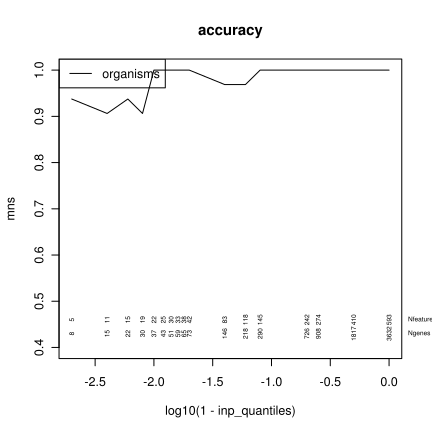

In [58]:
%%R
load('Untitled11.RData')
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
mns <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)tmp2[[lev]]$predicted==unlist(tmp2[[lev]]$actual))))))
names(mns)<-names(qqq$organisms[[1]])
mns<-mns[length(mns):1]
expr_levels = quantile(apply(x.ranks,1,median),inp_quantiles)
n_genes <- sapply(expr_levels,function(lev)sum(apply(x.ranks,1,median)>lev))

n_features <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)length(tmp2[[lev]]$features))))))
names(n_features)<-names(qqq$organisms[[1]])
n_features<-n_features[length(n_features):1]

plot(log10(1-inp_quantiles),mns,typ='l',main='accuracy', ylim=c(0.4,1.0))
legend('topleft',legend=names(qqq),lwd=1,col=1:4)
#text(log10(1-inp_quantiles), 0.5, lab=as.character(round(expr_levels)),cex=0.5,srt=90, xpd=NA)
#text(0.1, 0.5, lab='Rank', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.43, lab=as.character(n_genes),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.43, lab='Ngenes', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.46, lab=as.character(round(n_features)),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.46, lab='Nfeatures', pos=4, cex=0.5, xpd=NA)

NULL

### Get list of (importance-ranked) genes for each condition...

### organisms (i.e., for DvH, is it mono- or co-culture)

 [1] "DVU0148" "DVU2103" "DVU2104" "DVU0540" "DVU0149" "DVU0535" "DVU0961"
 [8] "DVU1295" "DVU0139" "DVU0140" "DVU0262" "DVU3026" "DVU0997" "DVU2448"
[15] "DVU0270" "DVU0536" "DVU2109" "DVU2287" "DVU0261" "DVU2947" "DVU0401"
[22] "DVU0529" "DVU1536" "DVU2289" "DVU0041" "DVU2105" "DVU0530" "DVU0269"
[29] "DVU2299" "DVU2286"


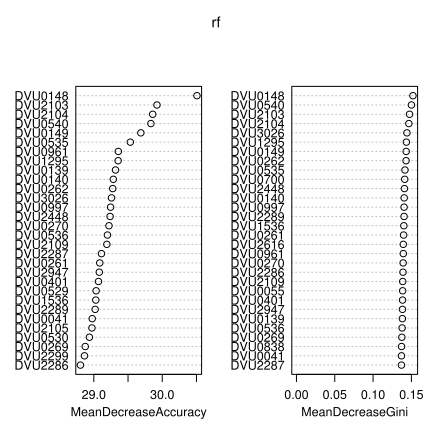

In [61]:
%%R
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$organisms,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp==length(qqq$organisms)])
rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
varImps = varImpPlot(rf) ##; print(rf)
varImps = varImps[ order(varImps[,1], decreasing=T), ]
imp_genes = rownames(varImps)[1:30]

In [62]:
%Rpull imp_genes

query = '%22'+'%22+%22'.join(imp_genes)+'%22'
query = 'http://networks.systemsbiology.net/search?q='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

http://networks.systemsbiology.net/search?q=%22DVU0148%22+%22DVU2103%22+%22DVU2104%22+%22DVU0540%22+%22DVU0149%22+%22DVU0535%22+%22DVU0961%22+%22DVU1295%22+%22DVU0139%22+%22DVU0140%22+%22DVU0262%22+%22DVU3026%22+%22DVU0997%22+%22DVU2448%22+%22DVU0270%22+%22DVU0536%22+%22DVU2109%22+%22DVU2287%22+%22DVU0261%22+%22DVU2947%22+%22DVU0401%22+%22DVU0529%22+%22DVU1536%22+%22DVU2289%22+%22DVU0041%22+%22DVU2105%22+%22DVU0530%22+%22DVU0269%22+%22DVU2299%22+%22DVU2286%22


NULL


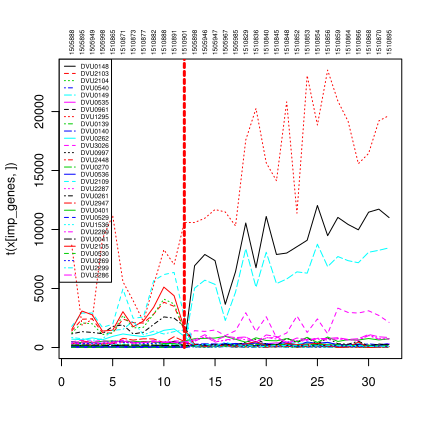

In [80]:
%%R
x = as.matrix(x[,colnames(x)%in%colnames(x.ranks)])
x = cbind(x[,Y=='D vulgaris Hildenborugh'], x[,Y=='D vulgaris Hildenborugh and M maripaludis'])
#load('qqq')
matplot(t(x[imp_genes,]), typ='l')
legend('topleft', legend=imp_genes, cex=0.5, col=1:6, lty=1:5)
lines(rep(sum(Y=='D vulgaris Hildenborugh'),2), c(0,99999), col='red', lty=2, lwd=3)
text(x=1:ncol(x), y=rep(max(x[imp_genes,])*1.1,ncol(x)),gsub('Sample_US.','',colnames(x)), srt=90, cex=0.5, xpd=NA)
NULL

NULL


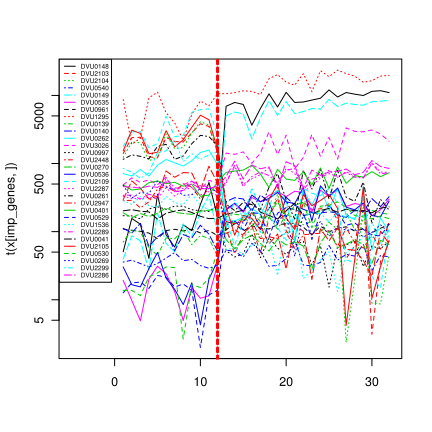

In [70]:
%%R
matplot(t(x[imp_genes,]), typ='l', log='y', xlim=c(-5, ncol(x)))
legend('topleft', legend=imp_genes, cex=0.5, col=1:6, lty=1:5)
lines(rep(sum(Y=='D vulgaris Hildenborugh'),2), c(1,100000), col='red', lty=2, lwd=3)
NULL

1.982882 1.868486 
0.5826936 0.578767 

	Welch Two Sample t-test

data:  tmp1 and tmp2
t = 26.2384, df = 85838.24, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.09753398 0.11328176
sample estimates:
mean of x mean of y 
 2.016620  1.911213 

NULL


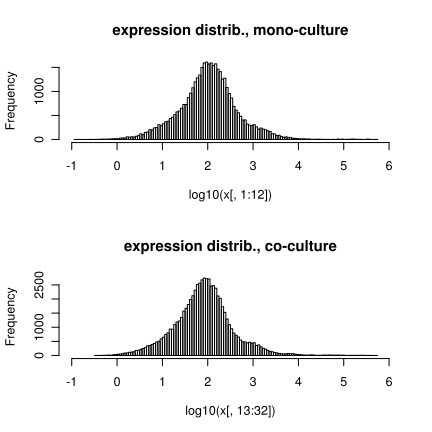

In [79]:
%%R
par(mfrow=c(2,1))
hist(log10(x[,1:12]),breaks=200, main='expression distrib., mono-culture', xlim=c(-1,6))
hist(log10(x[,13:32]),breaks=200, main='expression distrib., co-culture', xlim=c(-1,6))
cat(median(log10(x[,1:12])), median(log10(x[,13:32])), '\n')
cat(mad(log10(x[,1:12])), mad(log10(x[,13:32])), '\n')
tmp1=log10(x[, 1:12]);tmp1=tmp1[!is.infinite(tmp1)]
tmp2=log10(x[, 13:32]);tmp2=tmp2[!is.infinite(tmp2)]
print(t.test(tmp1,tmp2))
NULL